# ZIKV DMS analysis with mAb selections (ZKA64 and ZKA185)

Deep mutational scanning of Zika virus MR-766 (1947, Uganda) envelope (E) protein. ZKA64 and ZKA185 are human monoclonal antibodies (Absolute Antibody, Oxford, UK). Experiments by Evans Lab (Sourisseau et al., 2019 JVI). 

In [1]:
# import tools
import os
import glob
import numpy
import pandas as pd

from Bio import SeqIO

import dms_tools2
from dms_tools2.ipython_utils import showPDF

In [2]:
# ID input/output directories
samplelist = './data/samplelist.csv'
datadir = './data/'
resultsdir = './results/'
os.makedirs(resultsdir, exist_ok=True)

In [3]:
# reference sequences
Erefseq = './data/E.fasta'
subamplicon_alignspecs = './data/subamplicon_alignspecs.txt'

In [4]:
# read in E protein sequence data 
refseq = SeqIO.read(Erefseq, 'fasta')
E_seq = refseq.seq
E_prot = E_seq.translate()

assert E_prot.count('*') == 0, 'protein seq contains unexpected stop codon(s)'

# Bio.SeqIO documention https://biopython.org/wiki/SeqIO

In [5]:
# read in sample list and add the sampleID 'name'
samples = (pd.read_csv(samplelist, index_col=False))
# pd.set_option('display.max_colwidth', None)
# code necessary for more recent versions of pandas (1.above) to set max column width

samples.insert(0, 'name', (samples['library'] + '-' + samples['selection']))
samples.style.hide_index()

name,library,selection,antibody,percent_infectivity,R1,SRA_accession
Lib1-plasmid,Lib1,plasmid,none,nan,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170609_SN367_0933_BHMLH5BCXY_lane2/Unaligned/Project_bloom_lab/Sample_zikv-1/*R1*.fastq.gz,SRR8878405
Lib2-plasmid,Lib2,plasmid,none,nan,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170609_SN367_0933_BHMLH5BCXY_lane2/Unaligned/Project_bloom_lab/Sample_zikv-2/*R1*.fastq.gz,SRR8878404
Lib3-plasmid,Lib3,plasmid,none,nan,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170609_SN367_0933_BHMLH5BCXY_lane2/Unaligned/Project_bloom_lab/Sample_zikv-3/*R1*.fastq.gz,SRR8878399
wildtype-plasmid,wildtype,plasmid,none,nan,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170609_SN367_0933_BHMLH5BCXY_lane2/Unaligned/Project_bloom_lab/Sample_zikv-wt/*R1*.fastq.gz,SRR8878396
Lib1-virus,Lib1,virus,none,nan,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180427_SN367_1155_BHHJMKBCX2/Unaligned/Project_bloom_lab/Sample_zikv_L1/*R1*.fastq.gz,SRR8878397
Lib2-virus,Lib2,virus,none,nan,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180427_SN367_1155_BHHJMKBCX2/Unaligned/Project_bloom_lab/Sample_zikv_L2/*R1*.fastq.gz,SRR8878395
Lib3-virus,Lib3,virus,none,nan,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180427_SN367_1155_BHHJMKBCX2/Unaligned/Project_bloom_lab/Sample_zikv_L3/*R1*.fastq.gz,SRR8878409
wildtype-virus,wildtype,virus,none,nan,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180427_SN367_1155_BHHJMKBCX2/Unaligned/Project_bloom_lab/Sample_zikv_WT/*R1*.fastq.gz,SRR8878408
Lib1-no-antibody,Lib1,no-antibody,no-antibody,71.06,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180928_D00300_0621_BHMJGNBCX2/Unaligned/Project_bloom_lab/Sample_Mock_Lib1_*/*R1*.fastq.gz,SRR8878411
Lib2-no-antibody,Lib2,no-antibody,no-antibody,132.77,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180928_D00300_0621_BHMJGNBCX2/Unaligned/Project_bloom_lab/Sample_Mock_Lib2_*/*R1*.fastq.gz,SRR8878398


In [6]:
# read in align specs
with open (subamplicon_alignspecs, 'r') as file:
    alignspecs = file.read().replace('\n','')
alignspecs

'1,303,33,38 304,609,38,40 610,903,41,36 904,1200,41,37 1201,1512,36,35'

In [7]:
# process deep sequencing data: run dms2_batch_subamp

# make folder where codon counts will go
codons_batch_subamp = os.path.join(resultsdir + 'codoncounts')
os.makedirs(codons_batch_subamp, exist_ok=True)

# tell me if sample path is missing
for c in samples['R1']:
    if c == 'NaN':
       raise ValueError('samples is missing a file path')

# create df and export csv with only name/R1 for dms2_batch_subamp   
batchfile = os.path.join(datadir + 'batchSubampIDs.csv')
samples[['name','R1']].to_csv(batchfile, index=False)

#use existing data
use_existing = 'yes'

# standard trim in Bloom lab analyses is 200 bp
# from documentation: "removes low-quality nucleotides that tend to be at the end of long reads"
R1TRIM = 200
R2TRIM = 200

#needs a name to run
baka = ! dms2_batch_bcsubamp \
    --batchfile {batchfile} \
    --refseq {Erefseq} \
    --alignspecs {alignspecs} \
    --outdir {codons_batch_subamp} \
    --summaryprefix summary \
    --R1trim 200 \
    --R2trim 200 \
    --ncpus 16 \
    --use_existing {use_existing}

# ! executes following code in the command line

# add column to df.samples that includes filepath to each codoncounts.csv
samples['codoncounts'] = codons_batch_subamp + '/' + samples['name'] + '_codoncounts.csv'

# tell me how you did
print(f'dms2_batch_bcsubamp {dms_tools2.__version__} aligned sequencing data and created codon count files in {codons_batch_subamp}')

dms2_batch_bcsubamp 2.6.10 aligned sequencing data and created codon count files in ./results/codoncounts


# Note: potential issue with unpinned conda environment
I had difficulty creating the venv with the pinned doc from the Bloom GitHub repo. I ended up using the unpinned env. I didn't have any issues until running the above cell: the code raised errors for each PDF generation step with the the following message, and would fail to generate PDFs of the sucessfully analyzed data:
    
    2021-08-31 14:02:36,810 - ERROR - Terminating dms2_batch_bcsubamp with ERROR
    Traceback (most recent call last):
      File "/home/ckikawa/.conda/envs/ZIKV_DMS/bin/dms2_batch_bcsubamp", line 179, in main
        dms_tools2.plot.plotCodonMutTypes(batchruns['name'],
      File "/home/ckikawa/.conda/envs/ZIKV_DMS/lib/python3.8/site-packages/dms_tools2/plot.py", line 498, in plotCodonMutTypes
        df = (counts[list(muttypes.values()) + ['ncounts', 'name']]
    TypeError: sum() got an unexpected keyword argument 'axis'

I checked the source code of the pandas version included in my ZIKV_DMS env (1.3.2), and axis is no longer accepted as an argument in the sum() function. It is (of course) accepted in the specificed version of pandas specified in the pinned ZIKV_DMS env yml (0.25.3). I updated my venv with the correct pandas version and then had no issue. 

# Note: printing results inline in jupyter notebook
I found a few options for this from the internet:

    from IPython.display import IFrame, display
    filepath = "file.pdf"
    IFrame(filepath, width=700, height=400)

The (better) method from the Bloom notebook just uses a function from dms_tools2:
   
    from dms_tools2.ipython_utils import showPDF
    showPDF(filename or [list of filenames])
    


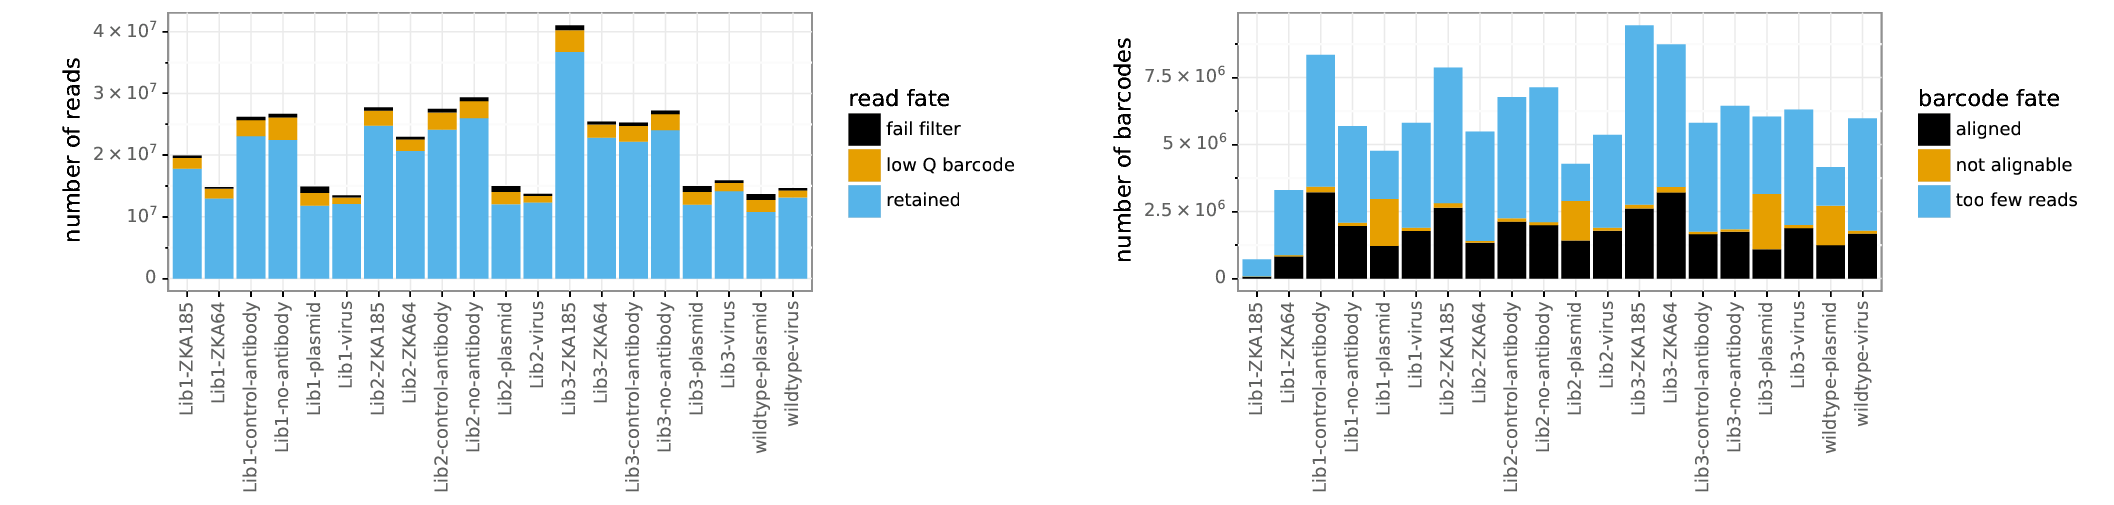

In [8]:
summary = codons_batch_subamp + "/summary_"

showPDF([os.path.join(summary + "readstats.pdf"),
         os.path.join(summary + "bcstats.pdf")])

LEFT, ABOVE: reads per sample. This run had an excess of reads. My samples will only require ~4.5e6. 
</p>RIGHT, ABOVE: barcodes per sample. All samples acheive goal #barcodes/sample except for lib1-ZKA185, which is likely due to a bottlenecking issue (quantification, math, or pipetting) when pooling PCR1 products (subamplicons) prior to PCR2. </p>

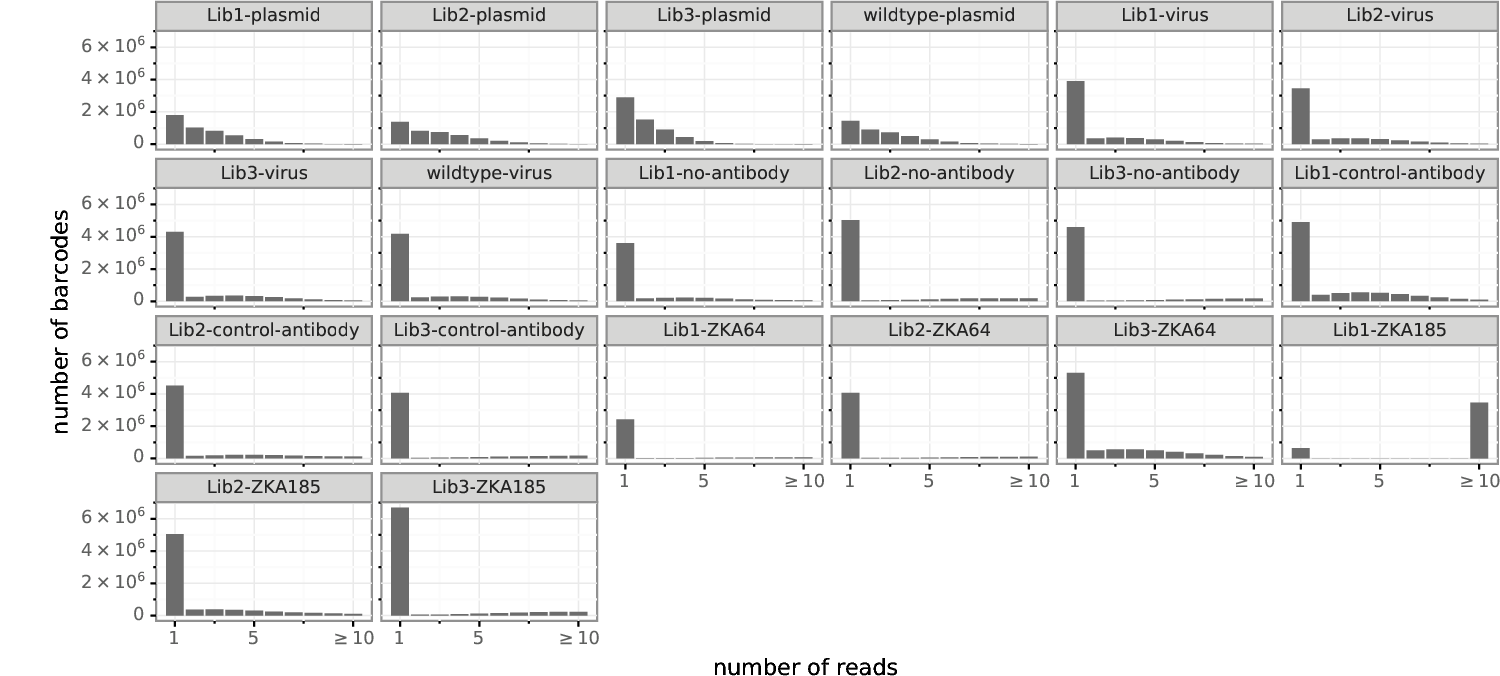

In [17]:
showPDF(os.path.join(summary + "readsperbc.pdf"))

ABOVE: reads per barcode. In the majority of samples, barcodes are being read >=1 time. We are only really shooting for barcodes being read twice (for error correction), so samples where barcodes are read >2 times at a consistent rate, reads are being wasted. Again, there is an issue with lib1-ZKA185 where, conversely, the majority of barcodes are read >2 times.  
</p>

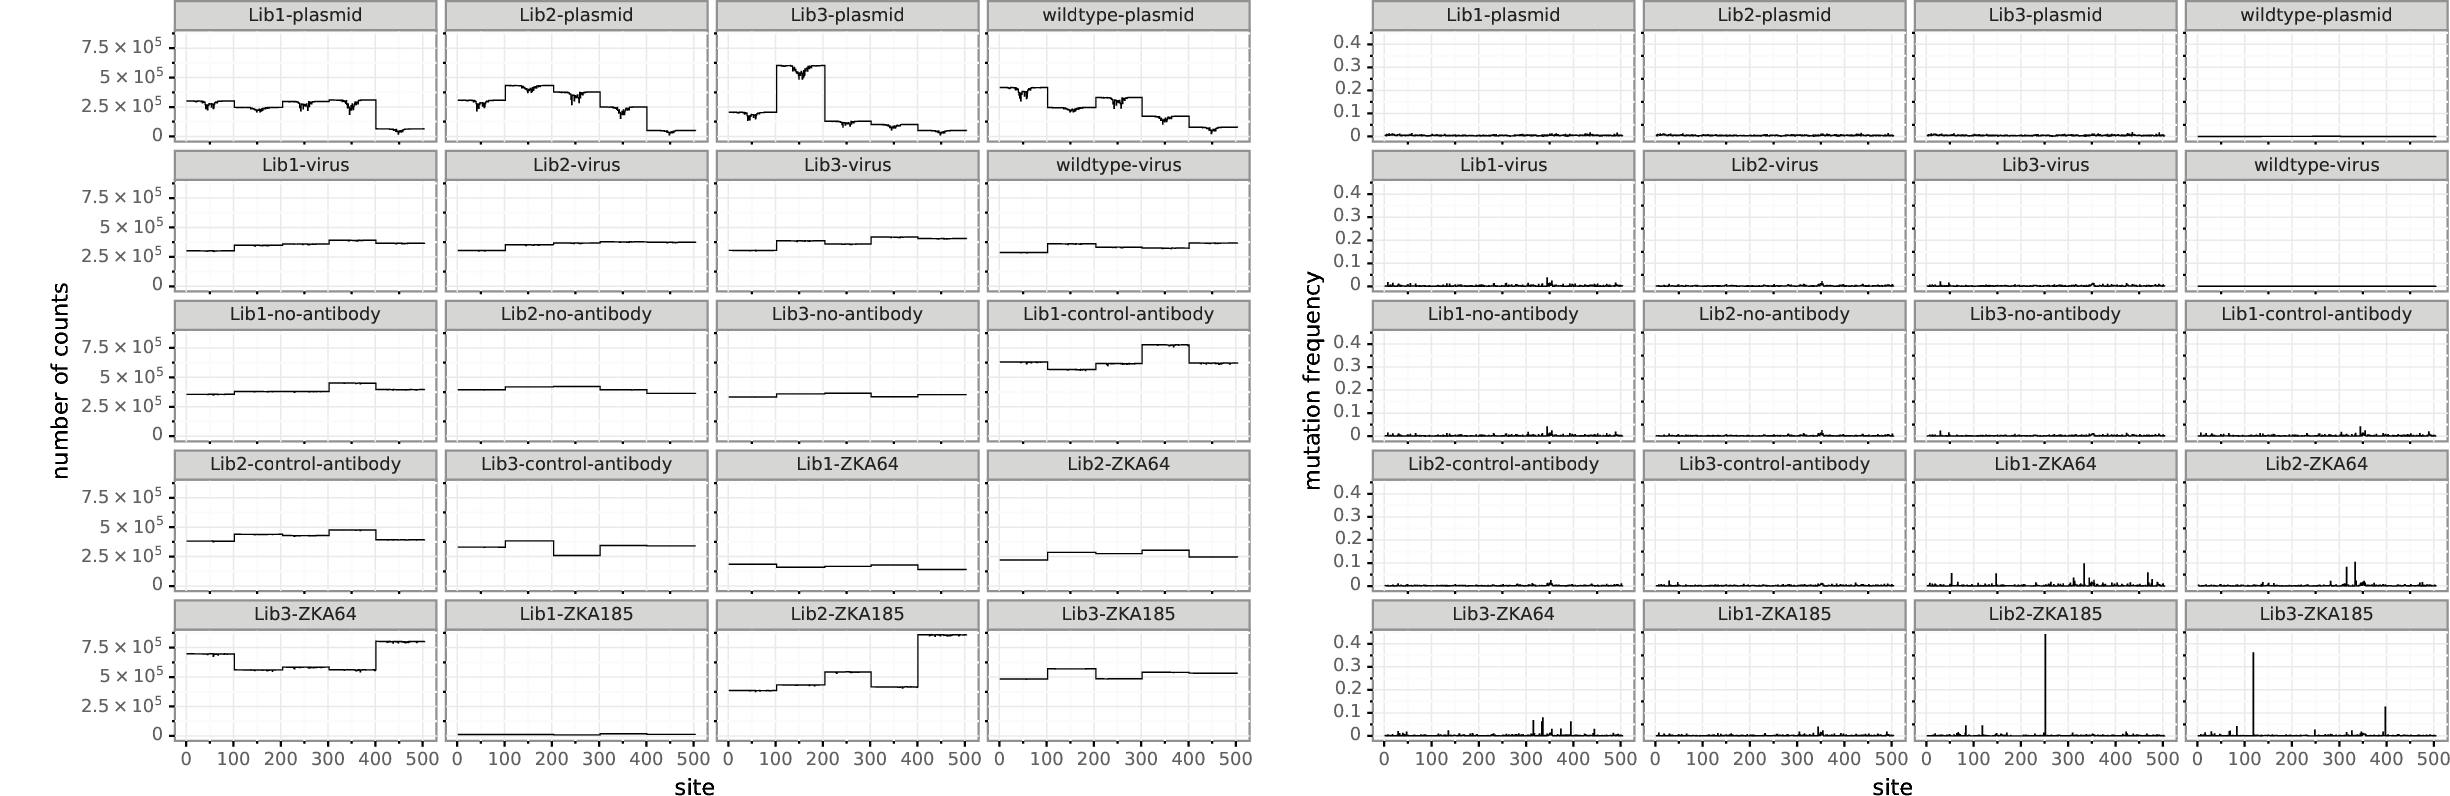

In [20]:
showPDF([os.path.join(summary + 'depth.pdf'),
         os.path.join(summary + 'mutfreq.pdf')])

LEFT, ABOVE: sequencing depth across 6 subamplicons. Fairly even except in the case of lib1-ZKA18 and plasmid library, which is more uneven coverage. 
</p>RIGHT, ABOVE: mutation frequency across 6 subamplicons. As expected, this is fairly even in the unselected conditions and more volatile in the antibody-selected conditions (indicating possible differential selection taking place). </p>

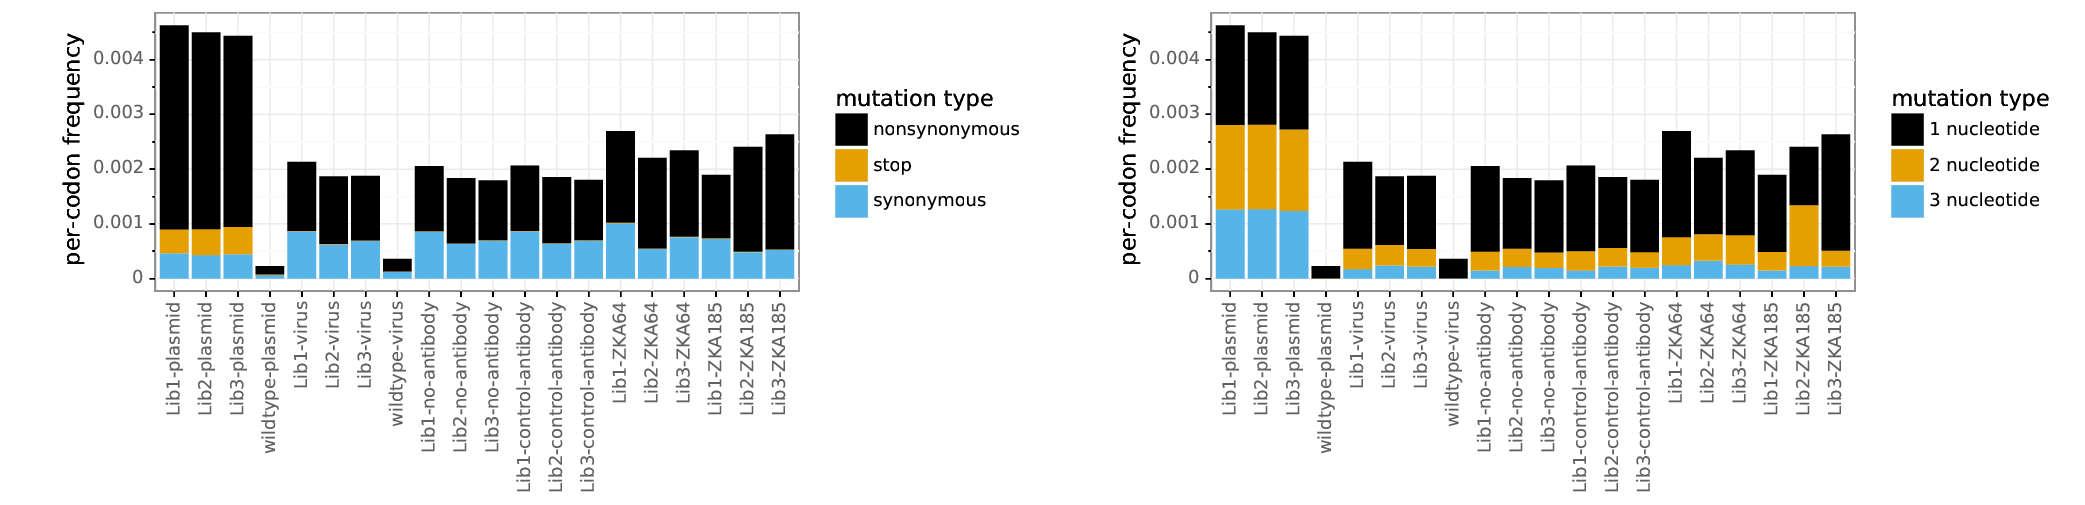

In [21]:
showPDF([os.path.join(summary + 'codonmuttypes.pdf'),
         os.path.join(summary + 'codonntchanges.pdf')])

LEFT, ABOVE: per-codon frequency of nonsynonymous, stop and synonymous mutations across samples. As expected, we see purging of stop codons in virus samples vs. plasmid libary samples. We also see purging of potentially fatal nonsynonymous mutations. 
</p>RIGHT, ABOVE: per-codon frequency of 1-, 2-, or 3-nuc mutations across samples. </p>

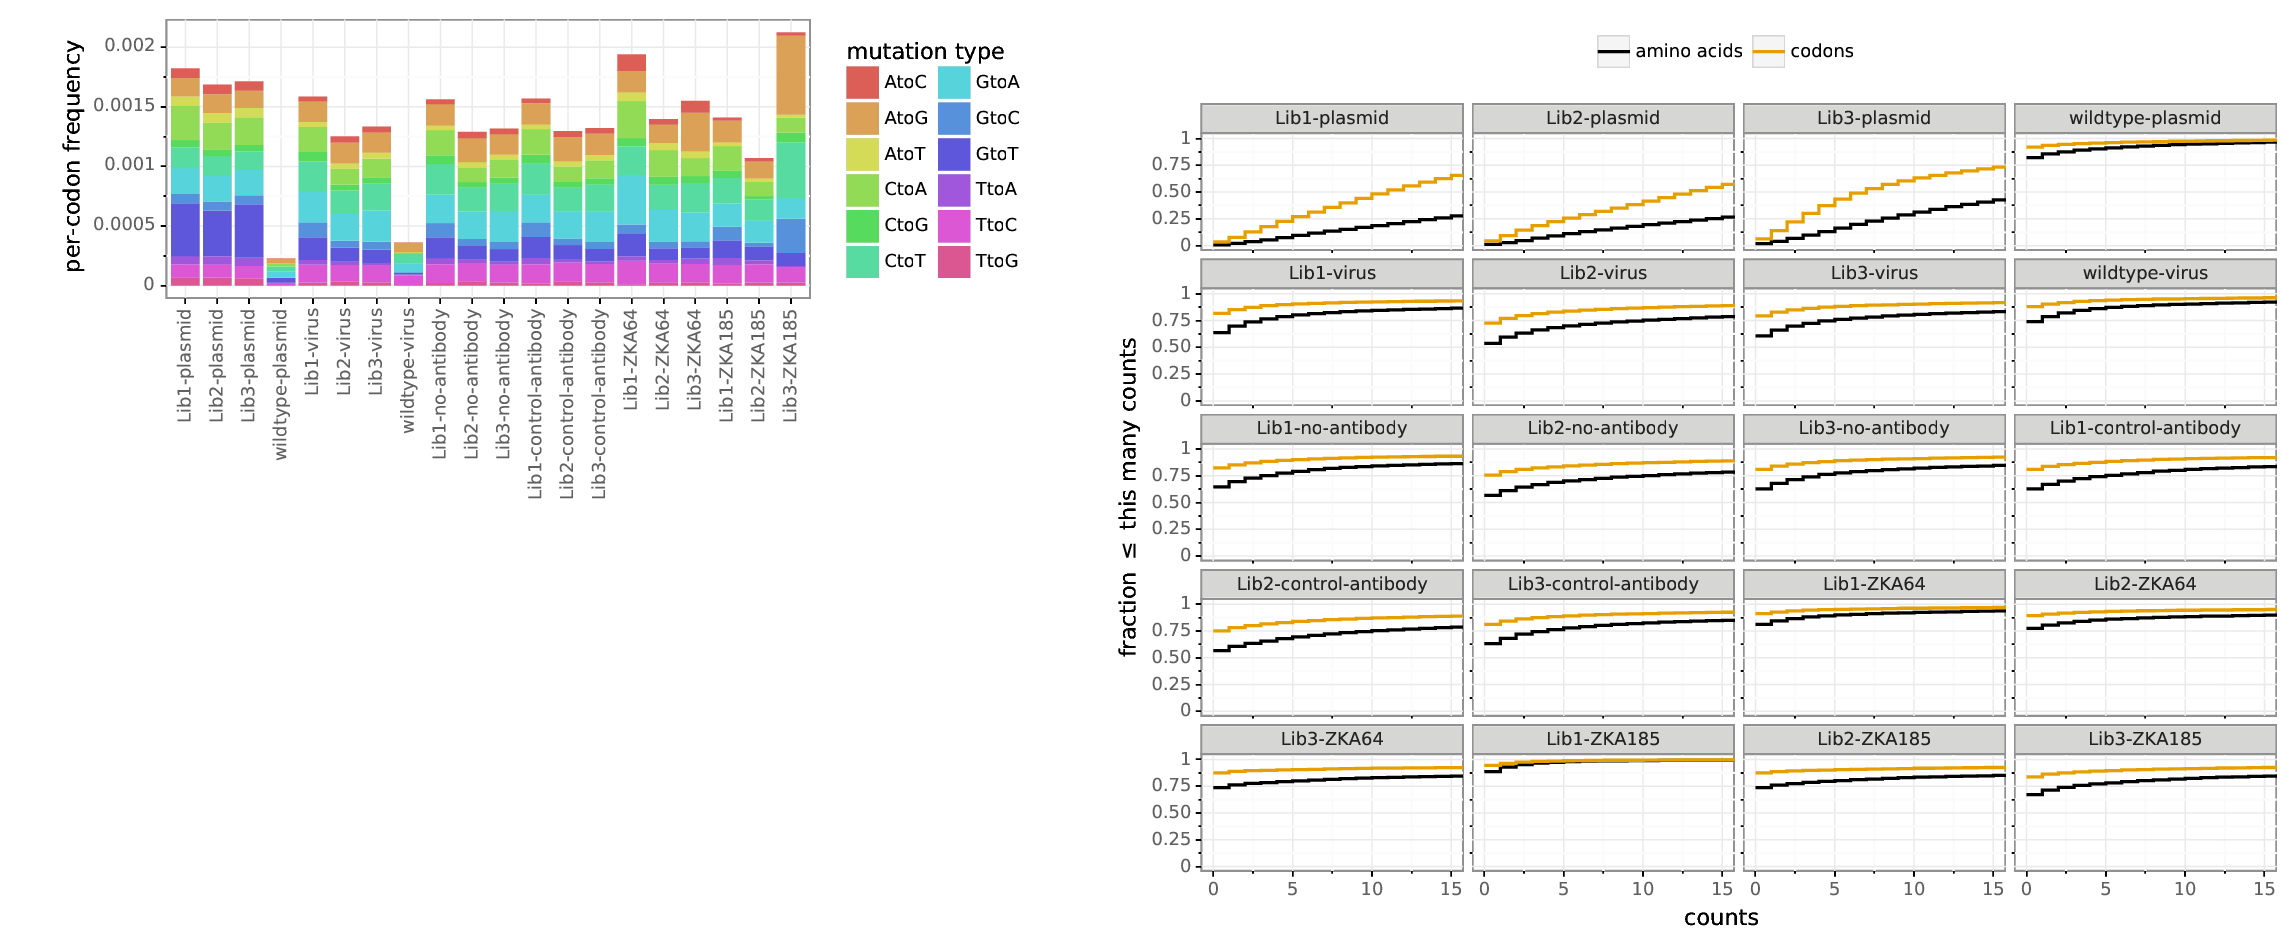

In [22]:
showPDF([os.path.join(summary + 'singlentchanges.pdf'),
         os.path.join(summary + 'cumulmutcounts.pdf')])

LEFT, ABOVE: per-codon frequency of various mutation types. We see some indication of oxidative damage in the plasmid library samples (). 
</p>RIGHT, ABOVE: fraction of mutations that occurs a given #(count) of times. In the wildtype, close to 100% of mutations occurs at a frequency of <1 times, as expected. Also as expected, the plasmid library contains a greater proportion of samples with mutation, while the virus library contains a significantly diminished proportion of mutations. </p>

# Differential selection

Next, I will use [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) to compute differential selection at each site along E protein in each sample. 

In [9]:
# make directory for diffsel results
diffsel_dir = os.path.join(resultsdir + 'diffsel/')
os.makedirs(diffsel_dir, exist_ok = True)

In [37]:
# make batchfile for diffsel
# must contain selection column 'sel'
# must contain mock column 'mock'
# must contain error correction column 'err'

none_index = samples[(samples['antibody'] == 'none')].index
noAb_index = samples[(samples['antibody'] == 'no-antibody')].index

diffsel = (
    samples.assign(sel = lambda x: x['name'],
                             mock = lambda x: x['library'] + '-no-antibody',
                                  err = 'wildtype-virus')
    .drop(columns = ['codoncounts', 'SRA_accession', 'R1', 'name'])
    .drop(none_index)
    .drop(noAb_index)
    .rename(columns = {'library' : 'name', 'selection' : 'group'})
    [['group', 'name', 'sel', 'mock', 'err', 'percent_infectivity']]
    .reset_index(drop=True)
)
diffsel

,group,name,sel,mock,err,percent_infectivity
0,control-antibody,Lib1,Lib1-control-antibody,Lib1-no-antibody,wildtype-virus,104.65000
1,control-antibody,Lib2,Lib2-control-antibody,Lib2-no-antibody,wildtype-virus,67.35000
2,control-antibody,Lib3,Lib3-control-antibody,Lib3-no-antibody,wildtype-virus,80.14000
3,ZKA64,Lib1,Lib1-ZKA64,Lib1-no-antibody,wildtype-virus,2.34000
4,ZKA64,Lib2,Lib2-ZKA64,Lib2-no-antibody,wildtype-virus,1.54000
5,ZKA64,Lib3,Lib3-ZKA64,Lib3-no-antibody,wildtype-virus,2.21000
6,ZKA185,Lib1,Lib1-ZKA185,Lib1-no-antibody,wildtype-virus,0.00059
7,ZKA185,Lib2,Lib2-ZKA185,Lib2-no-antibody,wildtype-virus,1.93000
8,ZKA185,Lib3,Lib3-ZKA185,Lib3-no-antibody,wildtype-virus,1.39000


In [38]:
# list columns for reordering purposes
cols = diffsel.columns.tolist()
cols

['group', 'name', 'sel', 'mock', 'err', 'percent_infectivity']

In [39]:
# write batchfile to csv
diffsel_batchfile = os.path.join(diffsel_dir + 'batch.csv')
diffsel.to_csv(diffsel_batchfile, index = False)

In [40]:
# run dms2_batch_diffsel
use_existing = 'no'

baka = ! dms2_batch_diffsel \
        --batchfile {diffsel_batchfile} \
        --summaryprefix summary \
        --indir {codons_batch_subamp} \
        --outdir {diffsel_dir} \
        --ncpus 16 \
        --use_existing {use_existing}

# Differential selection results
[dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) produces correlation plots (if the 'group' column was used, e.g. in the case of multiple replicates) for the absolute, positive and maximum differential selection at each site. There are the mean and median differential selection data files (.csv) and the plots to examine as well. By group (again -- if 'group' was used), mean and median diffsel are plotted as total diffsel (neg and pos diffsel), positive diffsel, minmax diffsel and max diffsel. 

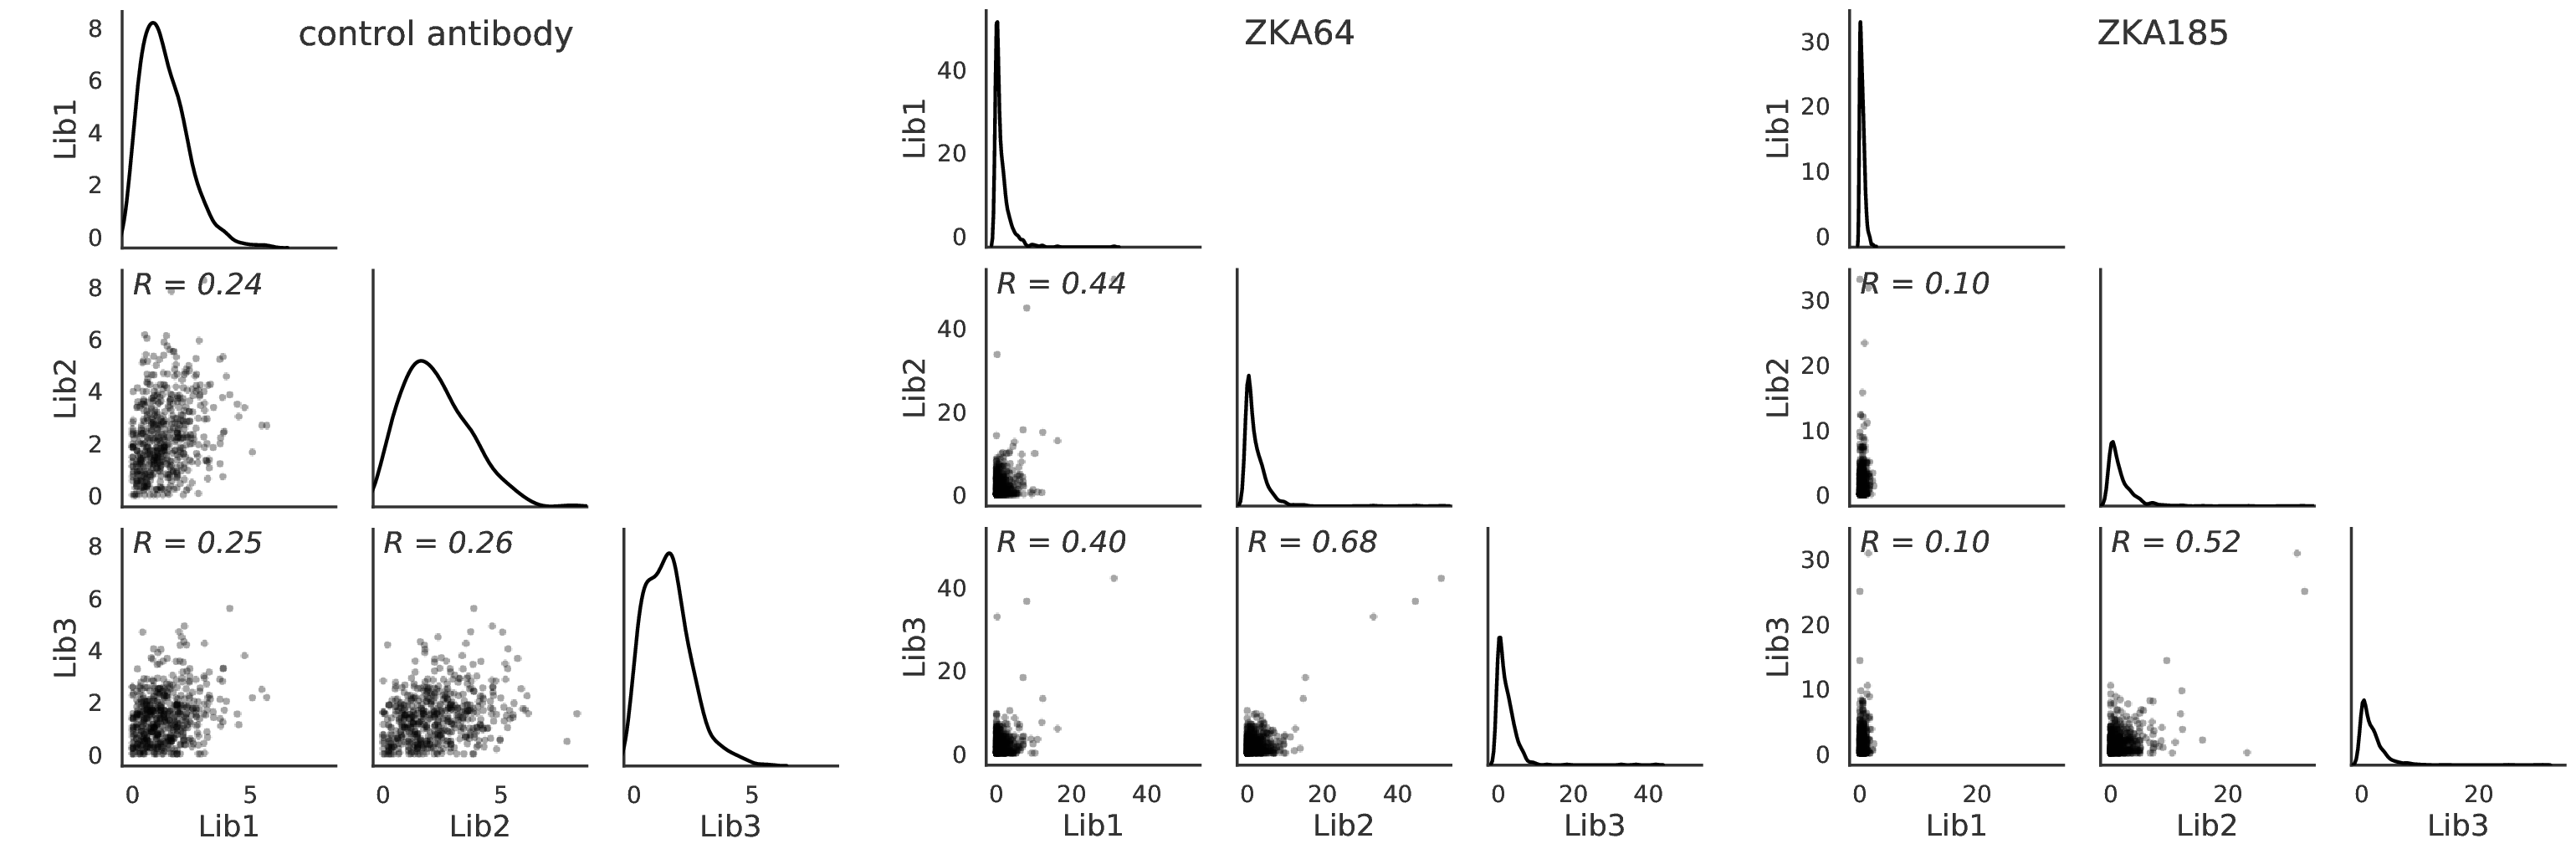

In [44]:
# my janky solution
ls = []         
for ab in diffsel['group'].unique():
         ls.append(os.path.join(diffsel_dir + 'summary_' + ab +'-positivesitediffselcorr.pdf'))
showPDF(ls)

# Jesse's much nicer f-string solution
# showPDF([os.path.join(diffsel_dir, f'summary_{ab}-positivesitediffselcorr.pdf')
#          for ab in diffsel['group'].unique()])

Above: <b>correlation plots</b> for each of the unique selection conditions (i.e. 'groups')

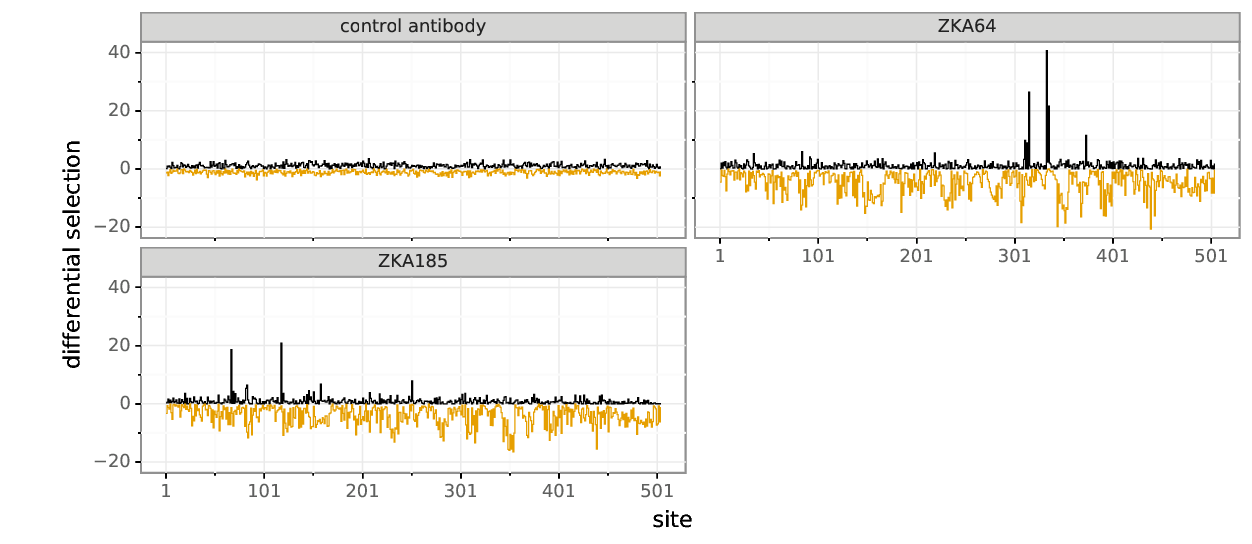

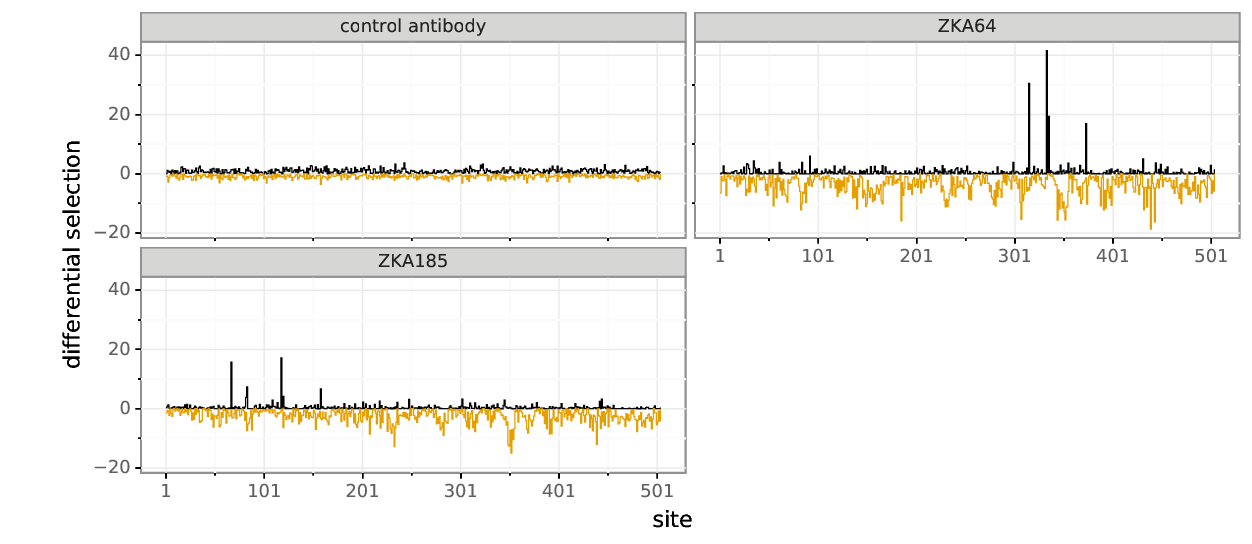

In [53]:
ls = ['summary_meantotaldiffsel.pdf',
      'summary_mediantotaldiffsel.pdf']

for l in ls: 
    showPDF(os.path.join(diffsel_dir, l))

ABOVE: comparing mean vs. median <b>total</b> differential selection across the three groups. Total diffsel includes <b> negative </b> selection, which is otherwise not plotted and generally not used by the Bloom lab in DMS analysis. 

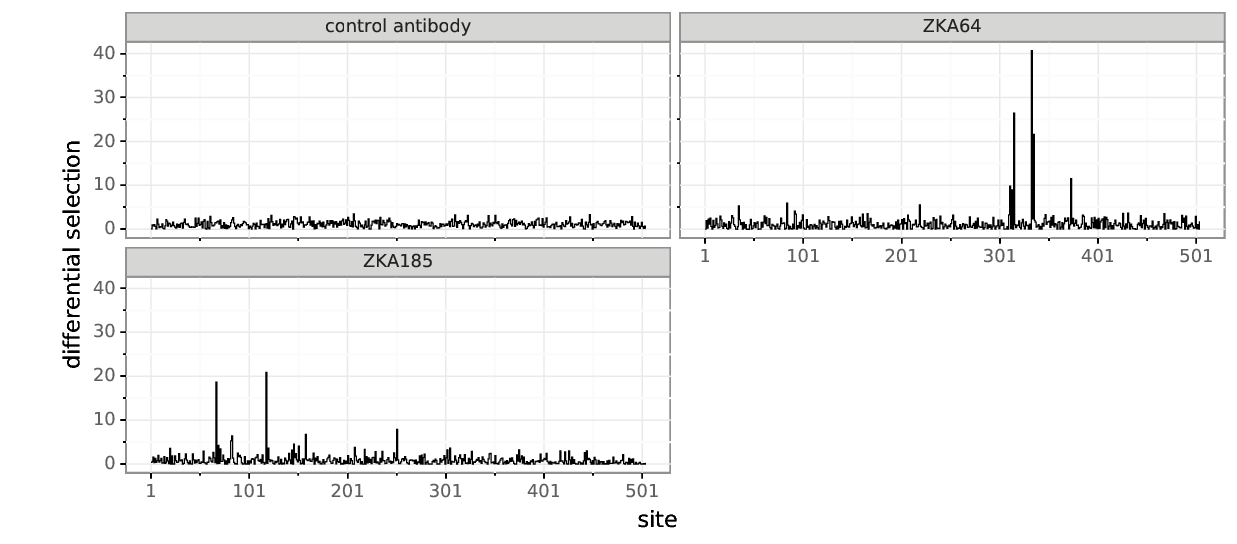

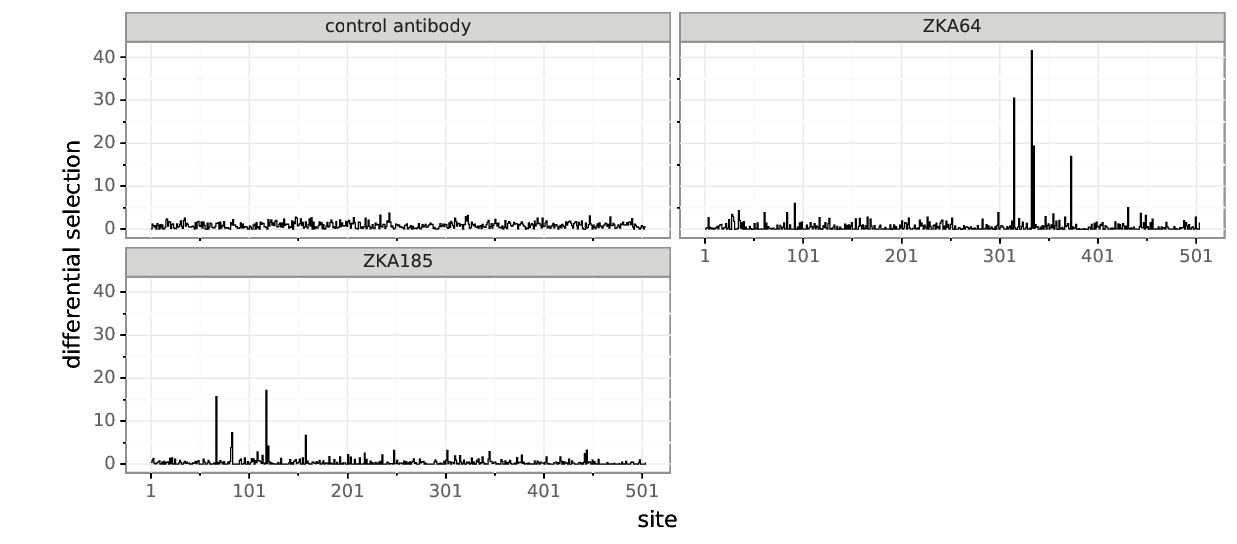

In [55]:
ls = ['summary_meanpositivediffsel.pdf',
      'summary_medianpositivediffsel.pdf']

for l in ls: 
    showPDF(os.path.join(diffsel_dir, l))

ABOVE: comparing mean vs. median <b>positive</b> differential selection across the three groups. This shows clear peaks in the selection antibodies and minimal noise in the control antibody, which is nonspecific against ZIKV. This result suggests positive selection is occuring.  

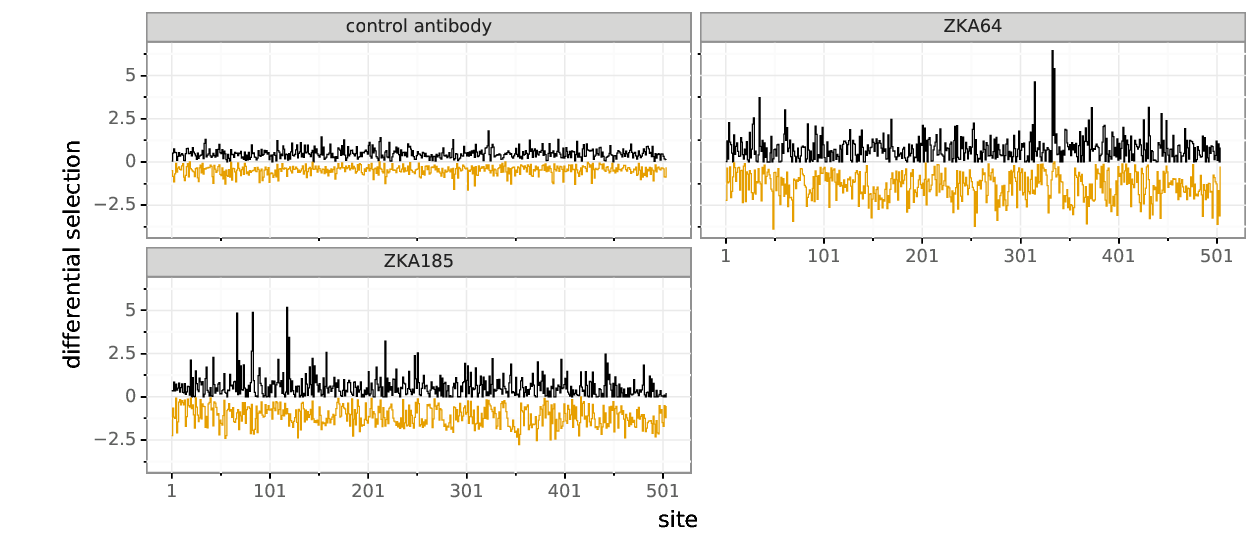

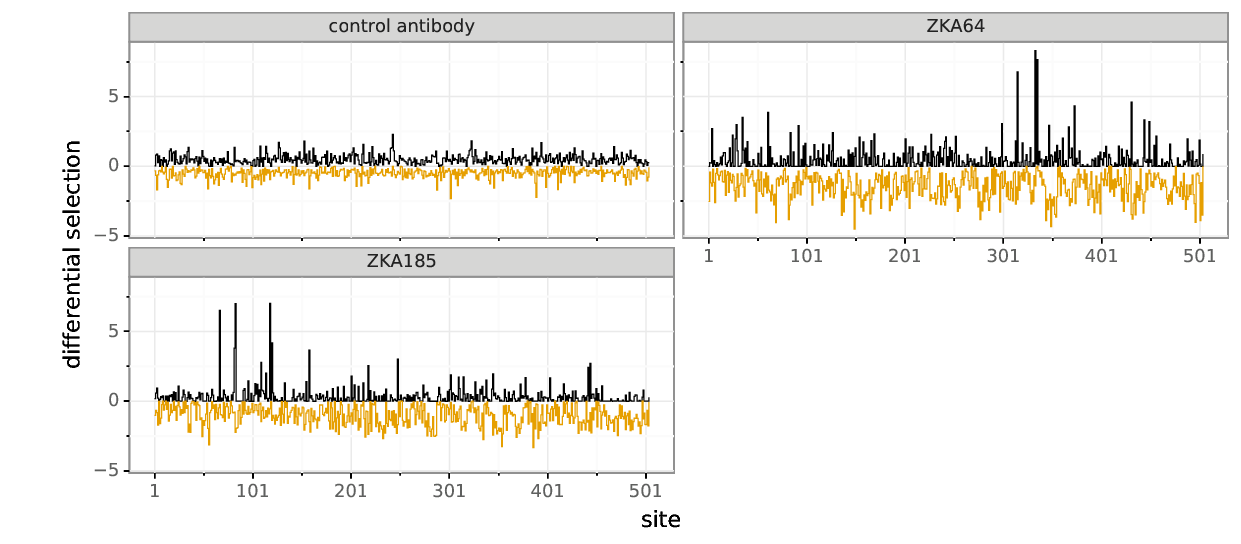

In [57]:
ls = ['summary_meanminmaxdiffsel.pdf',
      'summary_medianminmaxdiffsel.pdf']

for l in ls: 
    showPDF(os.path.join(diffsel_dir, l))

ABOVE: comparing mean vs. median <b>min-max</b> differential selection across the three groups. 

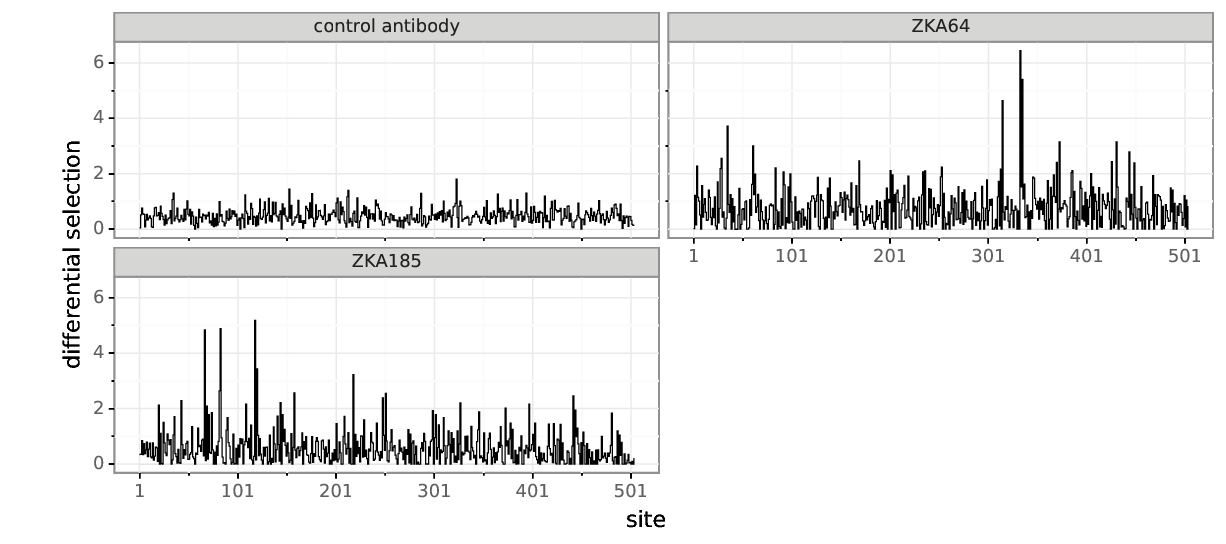

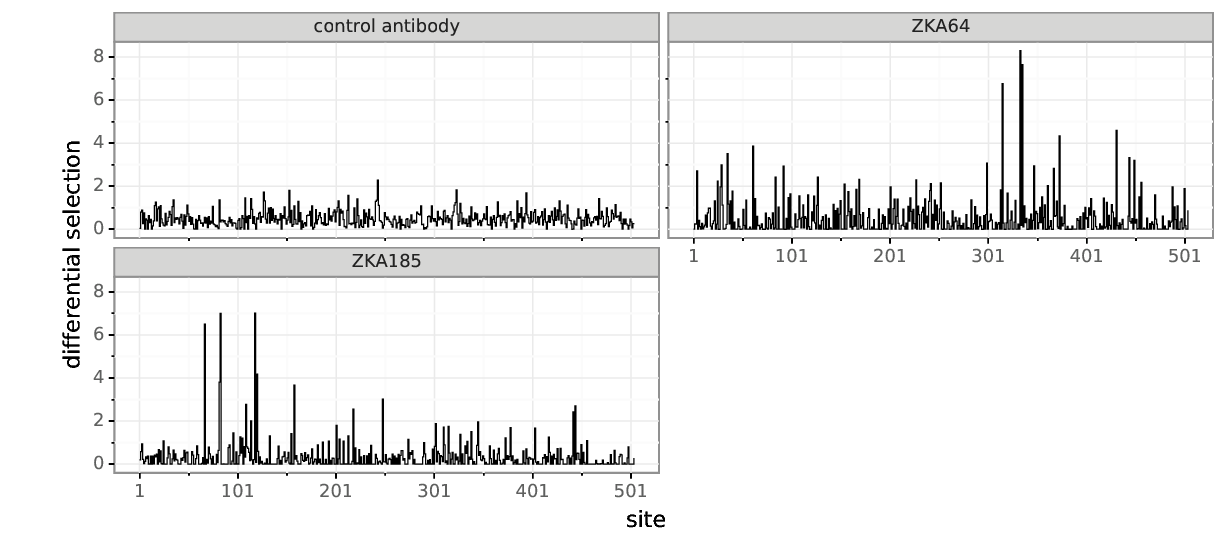

In [58]:
ls = ['summary_meanmaxdiffsel.pdf',
      'summary_medianmaxdiffsel.pdf']

for l in ls: 
    showPDF(os.path.join(diffsel_dir, l))

ABOVE: comparing mean vs. median <b>max</b> differential selection across the three groups.